# Bayesian degeneracies

In this notebook we play with the Bayesian inference from the population in order to understand if the degeneracies between cosmology and mass evolution can be broken

We convert our previous code to numpyro

In [1]:
import numpy as np

#Numpyro and friends
import numpyro
from numpyro.infer import NUTS,MCMC
import numpyro.distributions as dist
from jax import random
from jax import jit
from jax.config import config
import jax.numpy as jnp
from jax.scipy.special import erf
import arviz as az

config.update("jax_enable_x64", True)
nChains = 1
numpyro.set_host_device_count(nChains)

#PYTHON MODULES
from constants import *
from constants_gw import *
import jgwcosmo_wDM as jgwcosmo
import jgwpop

#PLOTS
import matplotlib.pyplot as plt
import corner
import sys
dir_base=sys.path[0]
dir_out=dir_base+"/plots_cosmo_mass_evolution/"

from matplotlib.ticker import ScalarFormatter
#%config InlineBackend.figure_format = 'retina'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']




---
Observed population

In [2]:
#Fiducial universe
Omk_fid = 0.00 # 0=flat


H0_fid  = 67.66     # cosmo.H(0).value #cosmology is Planck'18
zp_fid = 2.4
beta_fid = 3.4
kappa1_fid = 1.8
kappa2_fid = 5.
b_fid = 0.4
bq_fid = 0.0
r0_fid = 30.
dmMax_fid = 2.
dmMin_fid = 1.
tmp_min = 2.
tmp_max = 150.

w_fid=0
Om0_fid     = 0.30966  # cosmo.Om(0)
alpha_fid = -2.7
alpha_z_fid = 1.
f_peak_fid = 0.05
mmax_fid = 78.
mmin_fid = 10.
mu_m1_fid = 30.
sig_m1_fid = 7.
w_fid = 0.   #wDM fid = 0

---
Priors

In [3]:
#Priors
Om0_min, Om0_max         = 0.2,0.6   # fid~0.31
alpha_min, alpha_max     = 2.5, 2.9  # fid=-2.7
azmin, azmax             = 0.92,1.2   # fid=1
fmin, fmax               = 0.04,0.06 # fid=0.05
mmax_min, mmax_max       = 72., 82.  # fid=78
mmin_min, mmin_max       = 9.5, 10.4    # fid=10
mumin, mumax             = 10,50 # fid =30
sigmin, sigmax           = 5.5,7.8   # fid=7 **
w_min, w_max             = -0.1, 0.1 # wDM fid = 0


#w_min, w_max             = -1.5, -0.1  # w DE **********
#Omk_min, Omk_max         = -0.5,0.5    # **********
#h0_min, h0_max           = 0.4, 1.2   


kappa1_min, kappa1_max   = -4., 12.
kappa2_min, kappa2_max   = -4., 12.

b_min, b_max             = 0., 1.
beta_min, beta_max       = 0., 10.
zp_min, zp_max           = 0., 4.
gamma_min, gamma_max     = -10, 10
log10r0_min, log10r0_max = -3., 3.

---

---
# 1. Fiducial population without evolution

In [4]:
gamma1_fid = 0.
gamma2_fid = 0.

In [14]:
n_samples = 1
n_detections = 5000 #increase fx. x5 times. or more. vary it etc. then plot value vs N increasing
#H0 is local- but blakholes are in high z so this is not the best method to contrain H0
# try omk0 with only positive curv expressions and see if it is fixed
#cases-H0 Omk0,?Om0
#- omk, Om0
#/ Om0, wdm
#/ Om0, wDE

# read lambda cdm model - explain how we are doing extension of that
# calculate rate for future detectors

---
## Generate mock data

In [15]:
""" Inverse Sampling """
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
def inverse_transf_sampling(cum_values,variable,n_samples):
    inv_cdf = interp1d(cum_values, variable)
    r = np.random.uniform(min(cum_values),max(cum_values),n_samples)
    return inv_cdf(r)

def mock_source_parameters(n_sources,w,H0,Om0,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,zp,alpha_z,beta):
    zs = np.linspace(0.01,10.,10000)
    cdf_z = cumtrapz(jgwcosmo.diff_comoving_volume(zs,H0,Om0,w)*jgwpop.rate_z(zs,zp,alpha_z,beta)/(1+zs),zs,initial=0)
    cdf_z /= cdf_z[-1]
    
    masses = np.linspace(tmp_min,tmp_max,10000)
    cdf_m1 = cumtrapz(jgwpop.powerlaw_peak(masses,mmin,mmax,alpha,sig_m1,mu_m1,f_peak),masses,initial=0)
    # the power law of mass dist(2 peaks)
    cdf_m1 /= cdf_m1[-1]

    z_mock = inverse_transf_sampling(cdf_z,zs,n_sources)
    m1_mock = inverse_transf_sampling(cdf_m1,masses,n_sources)
    m2_mock = np.random.uniform(mmin,m1_mock,n_sources)
    #### dL_mock = jgwcosmo.dL_approx(z_mock,H0,Om0)
    #### = REPLACED APPROX FUNCTIONS
    dL_mock = jgwcosmo.d_L(z_mock,H0,Om0,w)
    m1z_mock = (1 + z_mock) * m1_mock
    m2z_mock = (1 + z_mock) * m2_mock
    return m1z_mock, m2z_mock, dL_mock

For the perfect measurement we only have one sample directly associated to the mock event

In [16]:
n_sources = n_detections

m1z_mock_CE, m2z_mock_CE, dL_mock_CE = mock_source_parameters(n_sources,w_fid,H0_fid,Om0_fid,mmin_fid,mmax_fid,alpha_fid,sig_m1_fid,mu_m1_fid,f_peak_fid,zp_fid,alpha_z_fid,beta_fid)

#THis is not really necessary because only 1 sample...but was introduced for the more general case
m1z_mock_samples_CE = np.zeros((n_detections,n_samples))
m2z_mock_samples_CE = np.zeros((n_detections,n_samples))
dL_mock_samples_CE = np.zeros((n_detections,n_samples))
jacob_mock_samples_CE = np.ones((n_detections,n_samples))
for i in range(n_detections):
    m1z_mock_samples_CE[i,:], m2z_mock_samples_CE[i,:], dL_mock_samples_CE[i,:] = m1z_mock_CE[i], m2z_mock_CE[i], dL_mock_CE[i]



---
## Likelihood


In [17]:
def log_Rz(z,r0,zp,alpha,beta):
    c0 = jnp.log1p((1. + zp)**(-alpha-beta))
    num = (1.+z)**alpha
    den = 1. + ((1.+z)/(1.+zp))**(alpha+beta)
    return jnp.log(r0) + c0  + alpha*jnp.log1p(z) - jnp.log1p(jnp.power((1.+z)/(1.+zp),(alpha+beta)))

def log_cosmo(z,H0,Om0,w):
    ####
    dL = jgwcosmo.d_L(z,H0,Om0,w)#Mpc
    Ez_i = jgwcosmo.Ez_inv(z,Om0,w)
    D_H = (Clight/1e3)  / H0 #Mpc
    
    logdiff_comoving_volume = jnp.log(1.0e-9) + jnp.log(4*jnp.pi) + 2*jnp.log(dL) +jnp.log(D_H) +jnp.log(Ez_i)-2*jnp.log1p(z)
    ddLdz = dL/(1.+z) + (1. + z)*D_H * Ez_i #Mpc 
    logJacobian = jnp.log(jnp.abs(ddLdz))#Jac has absolute value 
    return logdiff_comoving_volume - jnp.log1p(z) - logJacobian 

def logNdet_events(m1,m2,z,p_draw,w,H0,Om0,r0,Tobs,zp,alpha_z,beta,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,bq,Nsamples):
    #input data (N,M): N detections x M samples
    log_pm1 = jnp.log(jgwpop.powerlaw_peak(m1,mmin,mmax,alpha,sig_m1,mu_m1,f_peak)) - jnp.log1p(z) #(1+z) from Jac prior
    log_pm2 = 0 #NOT adding this at the moment #jnp.log(jgwpop.powerlaw_smooth(m2,mmin,m1,bq)) - jnp.log1p(z) #(1+z) from Jac prior
    log_pm = log_pm1 + log_pm2
    logcosmo = log_cosmo(z,H0,Om0,w)
    logRzs = log_Rz(z,r0,zp,alpha_z,beta) + jnp.log(Tobs)
    log_dN = log_pm + logcosmo + logRzs - jnp.log(p_draw)
    
    m = 0 #jnp.transpose(jnp.transpose(jnp.max(log_dN,axis=1))*jnp.ones((Nsamples,1)))
    return jnp.sum(m + jnp.log(jnp.sum(jnp.exp(log_dN-m),axis=1)) - jnp.log(Nsamples))

_Possible improvements_

- Only call dL once by computing the redshift normalization aty the same time
- 2D normaliztion for masses, 3D for mass evolution?


In [18]:
@jit
def log_lik(w,h0,Om0,mmin,mmax,alpha,mu_m1,sig_m1,f_peak,alpha_z,zp,beta):
    #Fixed parameters
    r0 = 1.0 # 10.**log10r0
    H0 = h0*100
    Tobs = 1.
    bq = bq_fid # We are not using m2 sitribution
    
    Nobs, Nsamples = jnp.shape(m1z_mock_samples_CE)
    
    D_H = (Clight/1.0e3)  / H0 #Mpc
    ####
    #m1_mock, m2_mock, z_mock = jgwcosmo.detector_to_source_frame_approx_dLdH(m1z_mock_samples_CE,m2z_mock_samples_CE,dL_mock_samples_CE/D_H,Om0,zmin=1e-3,zmax=100)
    m1_mock, m2_mock, z_mock = jgwcosmo.detector_to_source_frame(m1z_mock_samples_CE, m2z_mock_samples_CE, dL_mock_samples_CE,H0,Om0,w,zmin=1e-3,zmax=100)
    #print('m',m1_mock, m2_mock, z_mock)                        #(m1z, m2z, dL, H0, Om0, w, zmin=1e-3,zmax=100)
    #Log_lik Events
    p_draw = jacob_mock_samples_CE
    loglik_E = logNdet_events(m1_mock,m2_mock,z_mock,p_draw,w,H0,Om0,r0,Tobs,zp,alpha_z,beta,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,bq,Nsamples)

    zs_norm = jnp.linspace(0.01,10,1000) 
    ####
    dn_detec = jgwpop.rate_z(zs_norm,zp,alpha_z,beta)*jgwcosmo.diff_comoving_volume(zs_norm,H0,Om0,w)/(1.+zs_norm)   
    norm_z = jnp.trapz(dn_detec,zs_norm)
    loglik_E -= Nobs*jnp.log(norm_z)
    #print('loglik_E',loglik_E)
    m1s_norm = jnp.linspace(tmp_min,tmp_max,1000)    
    norm_m1 = jnp.trapz(jgwpop.powerlaw_peak(m1s_norm,mmin,mmax,alpha,sig_m1,mu_m1,f_peak),m1s_norm)
    loglik_E -= Nobs*jnp.log(norm_m1)
    
    #Selection effects
    loglik_N = 0.
    
    return loglik_N + loglik_E


#log_lik(0, 0.8139396015300265, 0.212839082203157, 16.66972424776207, 61.672686222534224, 1.5071812823795439, 50.81505348874913, 4.61719304924998, 0.8152541257648079, 1.5994087806939, 2.4, 3.4)

In [19]:
def log_probability():
    
    #Priors
    w = numpyro.sample("w",dist.Uniform(w_min,w_max))
    #Omk = 0.01 #numpyro.sample("Omk0",dist.Uniform(Omk_min,Omk_max))
    h0 = 67.66/100 #numpyro.sample("h0",dist.Uniform(h0_min,h0_max))
    Om0 = numpyro.sample("Om0",dist.Uniform(Om0_min,Om0_max))
    mmin = numpyro.sample("mmin",dist.Uniform(mmin_min,mmax_max))
    mmax = numpyro.sample("mmax",dist.Uniform(mmax_min,mmax_max))
    alpha = numpyro.sample("alpha",dist.Normal(alpha_min, alpha_max)) #0,5
    mu_m1 = numpyro.sample("mu_m1",dist.Uniform( mumin, mumax)) #20,60
    sig_m1 = numpyro.sample("sig_m1",dist.Uniform(sigmin, sigmax)) #1,10
    f_peak = numpyro.sample("f_peak",dist.Uniform(fmin, fmax))#0,1
    alpha_z = numpyro.sample("alpha_z",dist.Uniform(azmin, azmax))#numpyro.deterministic('alpha_z',alpha_z_fid)#numpyro.sample("alpha_z",dist.Normal(0,5))
    #Fixed
    zp = zp_fid #numpyro.deterministic('zp',zp_fid)
    beta = beta_fid #numpyro.deterministic('beta',beta_fid)
    #bq = numpyro.sample("bq",dist.Normal(0,5)) #when fitting m_2
    
    #Likelihood
    numpyro.factor("logp",log_lik(w,h0,Om0,mmin, mmax,alpha,mu_m1,sig_m1,f_peak,alpha_z,zp,beta))
    

In [20]:
rng_key = random.PRNGKey(2)
rng_key,rng_key_ = random.split(rng_key)

In [21]:
# Set up NUTS sampler over our likelihood
kernel = NUTS(log_probability)

#mcmc = MCMC(kernel,num_warmup=500,num_samples=2000,num_chains=nChains,chain_method='parallel')
##num_warmup=300,num_samples=3000
mcmc = MCMC(kernel,num_warmup=100,num_samples=200,num_chains=nChains,chain_method='parallel')

In [ ]:
mcmc.run(rng_key_)#, init_params=jnp.array([H0_fid/100, mmin_fid,mmax_fid,-2.7,5,30.,0.05])
mcmc.print_summary()
samples = mcmc.get_samples()

print('Fiducial values:')
print('H0=',H0_fid,', Om0=',Om0_fid)
print('w=',w_fid,'alpha=',alpha_fid,', bq=',bq_fid,', f_peak=',f_peak_fid,', mmax=',mmax_fid,', mmin=',mmin_fid,', mu_m1=',mu_m1_fid,', sig_m1=',sig_m1_fid)
print('alpha_z=',alpha_z_fid,', zp=',zp_fid,', beta=',beta_fid)

print('n_sources')

warmup:  18%|▏| 54/300 [04:43<51:19, 12.52s/it, 191 steps of size 2.54e-02. acc.

In [ ]:
az.plot_trace(mcmc)#, compact=True)
#plt.tight_layout()
#plt.savefig('chain_wDMfixH_2500new.png')
plt.show()



In [ ]:

fig = corner.corner(
    samples,quantiles=[0.16, 0.5, 0.84],smooth=1,label_kwargs={"fontsize": 14,"color":'silver'}, #labels=labels,
                       show_titles=True,title_kwargs={"fontsize": 14,"color":'white'},color='silver',
    truths=[Om0_fid,alpha_fid,alpha_z_fid,f_peak_fid,mmax_fid,mmin_fid,mu_m1_fid,sig_m1_fid,w_fid],#, truths=[H0_fid/100,alpha_ml, zp_ml]
truth_color='silver',no_fill_contours=True );
plt.tick_params(color='silver')
#corner.overplot_lines(fig, [alpha_fid,alpha_z_fid,f_peak_fid,mmax_fid,mmin_fid,mu_m1_fid,Om0_fid,sig_m1_fid,w_fid], marker="s",color="C1")
#corner.overplot_points(fig,np.array([w_fid,Om0_fid,alpha_fid,alpha_z_fid,f_peak_fid,mmax_fid,mmin_fid,mu_m1_fid,sig_m1_fid]) , marker="s", color="C2")
#plt.savefig('PICSnew/corner_wDM_1200_'+str(n_detections)+'Pts.pdf',transparent=True)
plt.show()

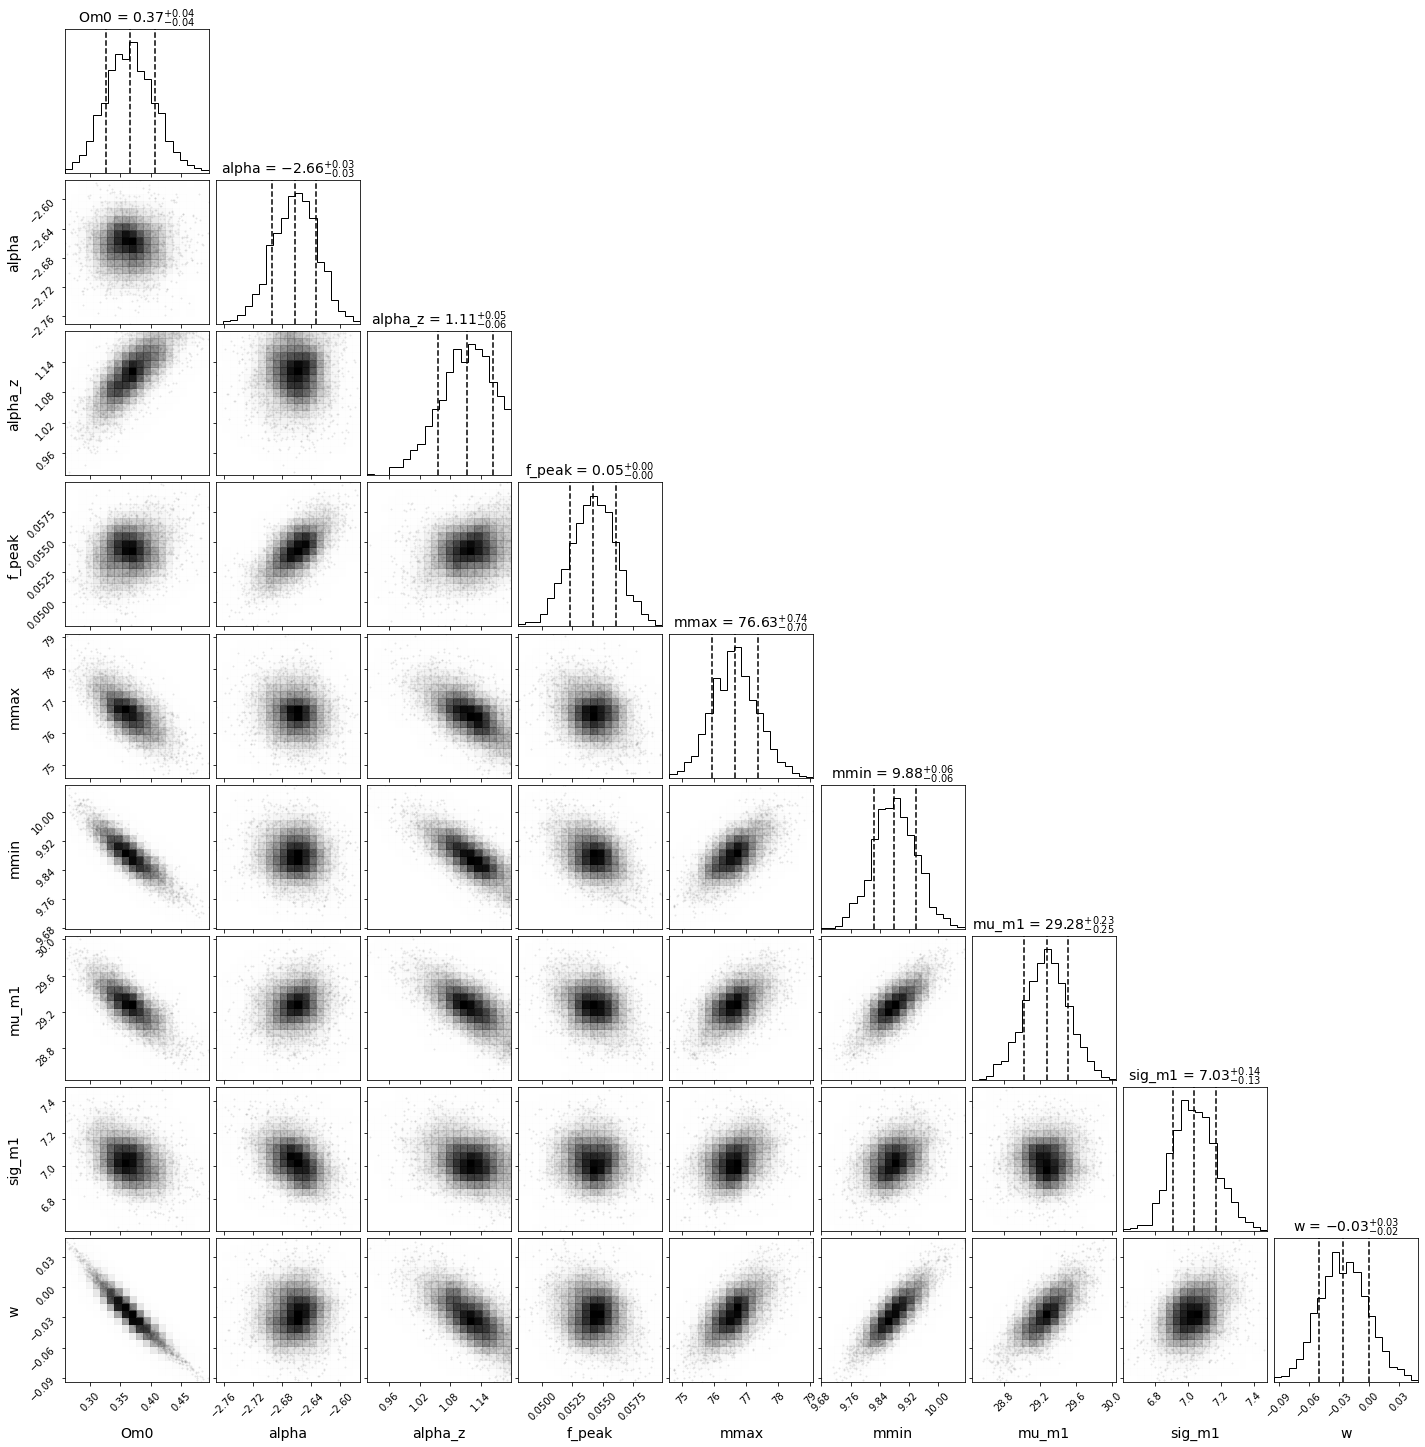

In [189]:
#black png version
fig = corner.corner(
    samples,quantiles=[0.16, 0.5, 0.84],#, labels=labels
                    smooth=1,label_kwargs={"fontsize": 14}, #labels=labels,
                       show_titles=True,title_kwargs={"fontsize": 14},
    #truths=[Om0_fid,alpha_fid,alpha_z_fid,f_peak_fid,H0_fid/100,mmax_fid,mmin_fid,mu_m1_fid,sig_m1_fid],#, truths=[H0_fid/100,alpha_ml, zp_ml]
 plot_contours=False,no_fill_contours=True 
                      #, truths=[H0_fid/100,alpha_ml, zp_ml]
);
plt.savefig('PICSnew/corner_wDM_1200_'+str(n_detections)+'Pts.png',transparent=True)
#plt.savefig('PICSnew/corner_Om0H0_2500_'+str(n_detections)+'Pts.png',transparent=True)
plt.show()

In [147]:
ndim, nsamples = 4, 50000
np.random.seed(1234)
data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape(
    [4 * nsamples // 5, ndim]
)

mean = 4 * np.random.rand(ndim)
data2 = mean[None, :] + np.random.randn(ndim * nsamples // 5).reshape(
    [nsamples // 5, ndim]
)
print(data1.shape)
Samples = np.vstack([data1, data2])

figure = corner.corner(Samples,hist_kwargs={transparent:True})

(40000, 4)


NameError: name 'transparent' is not defined

In [155]:
#dict = {'Python' : '.py', 'C++' : '.cpp', 'Java' : '.java'}

# open file for writing
f = open("samples_wDM_15k.txt","w")

# write file
f.write( str(samples) )

# close file
f.close()

In [159]:
f2 = open("samples_wDM_5k.txt","r")


corner.corner(np.array(f2))

ValueError: invalid input dimensions

In [138]:

data1=samples['w'].reshape(1)
data2=samples['Om0'].reshape(1)
subsamples = np.vstack([data1, data2])
f=corner.corner(
    subsamples,quantiles=[0.16, 0.5, 0.84],smooth=1)

TypeError: reshape total size must be unchanged, got new_sizes (1,) for shape (2000,).

In [55]:
mcmc.run(rng_key_)#, init_params=jnp.array([H0_fid/100, mmin_fid,mmax_fid,-2.7,5,30.,0.05])
mcmc.print_summary()
samples2 = mcmc.get_samples()

print('Fiducial values:')
print('H0=',H0_fid,', Om0=',Om0_fid)
print('w=',w_fid,'alpha=',alpha_fid,', bq=',bq_fid,', f_peak=',f_peak_fid,', mmax=',mmax_fid,', mmin=',mmin_fid,', mu_m1=',mu_m1_fid,', sig_m1=',sig_m1_fid)
print('alpha_z=',alpha_z_fid,', zp=',zp_fid,', beta=',beta_fid)



sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [1:15:21<00:00,  1.81s/it, 31 steps of size 9.74e-02. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       Om0      0.39      0.05      0.40      0.32      0.49    500.45      1.00
     alpha     -2.67      0.06     -2.67     -2.75     -2.57    883.67      1.00
   alpha_z      1.06      0.07      1.07      0.95      1.19    807.96      1.00
    f_peak      0.05      0.00      0.05      0.05      0.06   1067.11      1.00
      mmax     76.93      1.28     76.82     74.86     79.06    830.57      1.00
      mmin      9.83      0.08      9.83      9.71      9.97    578.09      1.00
     mu_m1     29.90      0.35     29.91     29.29     30.44    640.33      1.00
    sig_m1      6.53      0.22      6.52      6.17      6.88   1163.31      1.00
         w     -0.05      0.03     -0.05     -0.10     -0.01    526.78      1.00

Number of divergences: 0
Fiducial values:
H0= 67.66 , Om0= 0.30966
w= 0.0 alpha= -2.7 , bq= 0.0 , f_peak= 0.05 , mmax= 78.0 , mmin= 10.0 , mu_m1= 30.0 , sig_m1= 7.0
alpha_z= 1.0 , zp= 2.4 

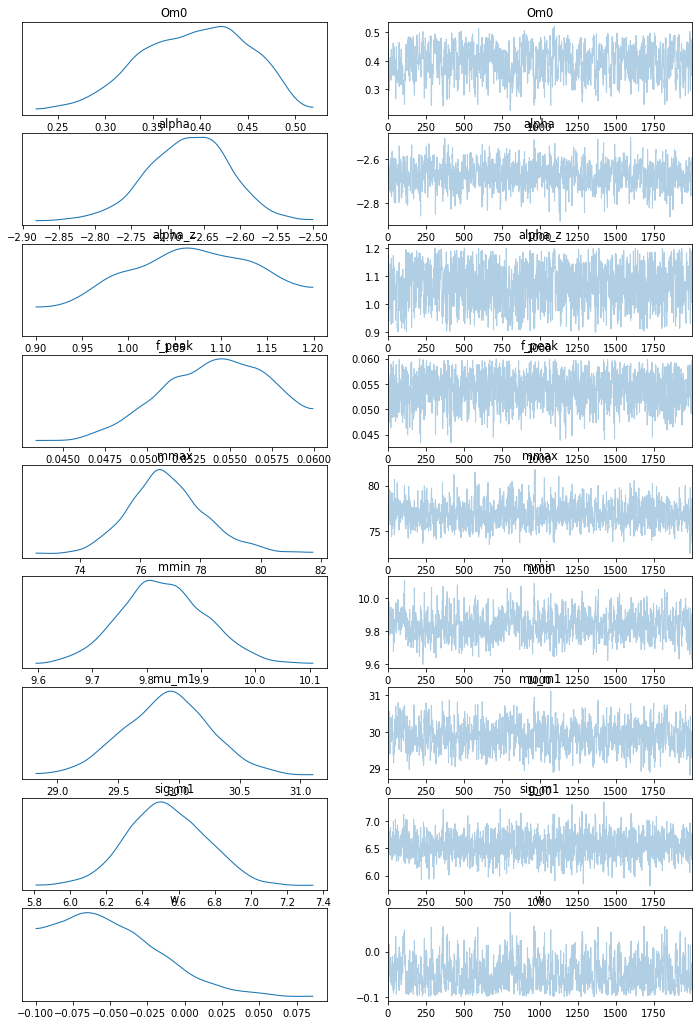

In [56]:
 

az.plot_trace(mcmc)#, compact=True)
#plt.tight_layout()
#plt.savefig('chain_wDMfixH_2500new.png')
plt.show()


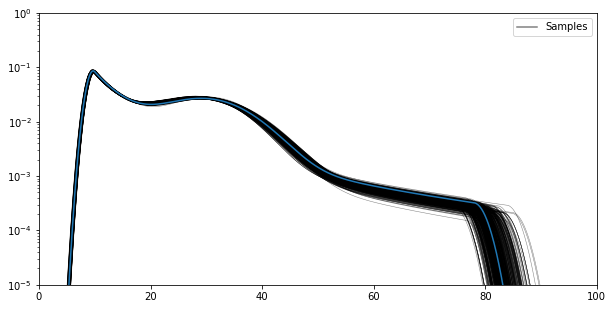

In [36]:
fig,ax = plt.subplots(figsize=(10,5))

m1_grid = np.linspace(2,150,1000)

random_inds = np.random.choice(np.arange(samples['mmax'].size),size=500)
for i in random_inds:
    
    p_m1 = jgwpop.powerlaw_peak(m1_grid,
                            samples['mmin'][i],
                           samples['mmax'][i],
                           samples['alpha'][i],
                            samples['sig_m1'][i],
                            samples['mu_m1'][i],
                            samples['f_peak'][i])
    p_m1 /= np.trapz(p_m1,m1_grid)
    
    ax.plot(m1_grid,p_m1,color='black',lw=0.5,alpha=0.5)

massess = np.linspace(2,150,1000)
pm_true = jgwpop.powerlaw_peak(massess,mmin_fid,mmax_fid,alpha_fid,sig_m1_fid,mu_m1_fid,f_peak_fid)
pm_true /= jnp.trapz(pm_true,massess)

ax.plot([],'k',alpha=0.5,label='Samples')
ax.semilogy(massess,pm_true)#,label='True')    

np.save('masses.npy',masses)
np.save('pmtrue.npy',pm_true)
ax.set_yscale('log')
ax.set_ylim(1e-5,1)
ax.set_xlim(0,100)
plt.legend()
#plt.savefig('mass_wfixH_2500.png')
plt.show()

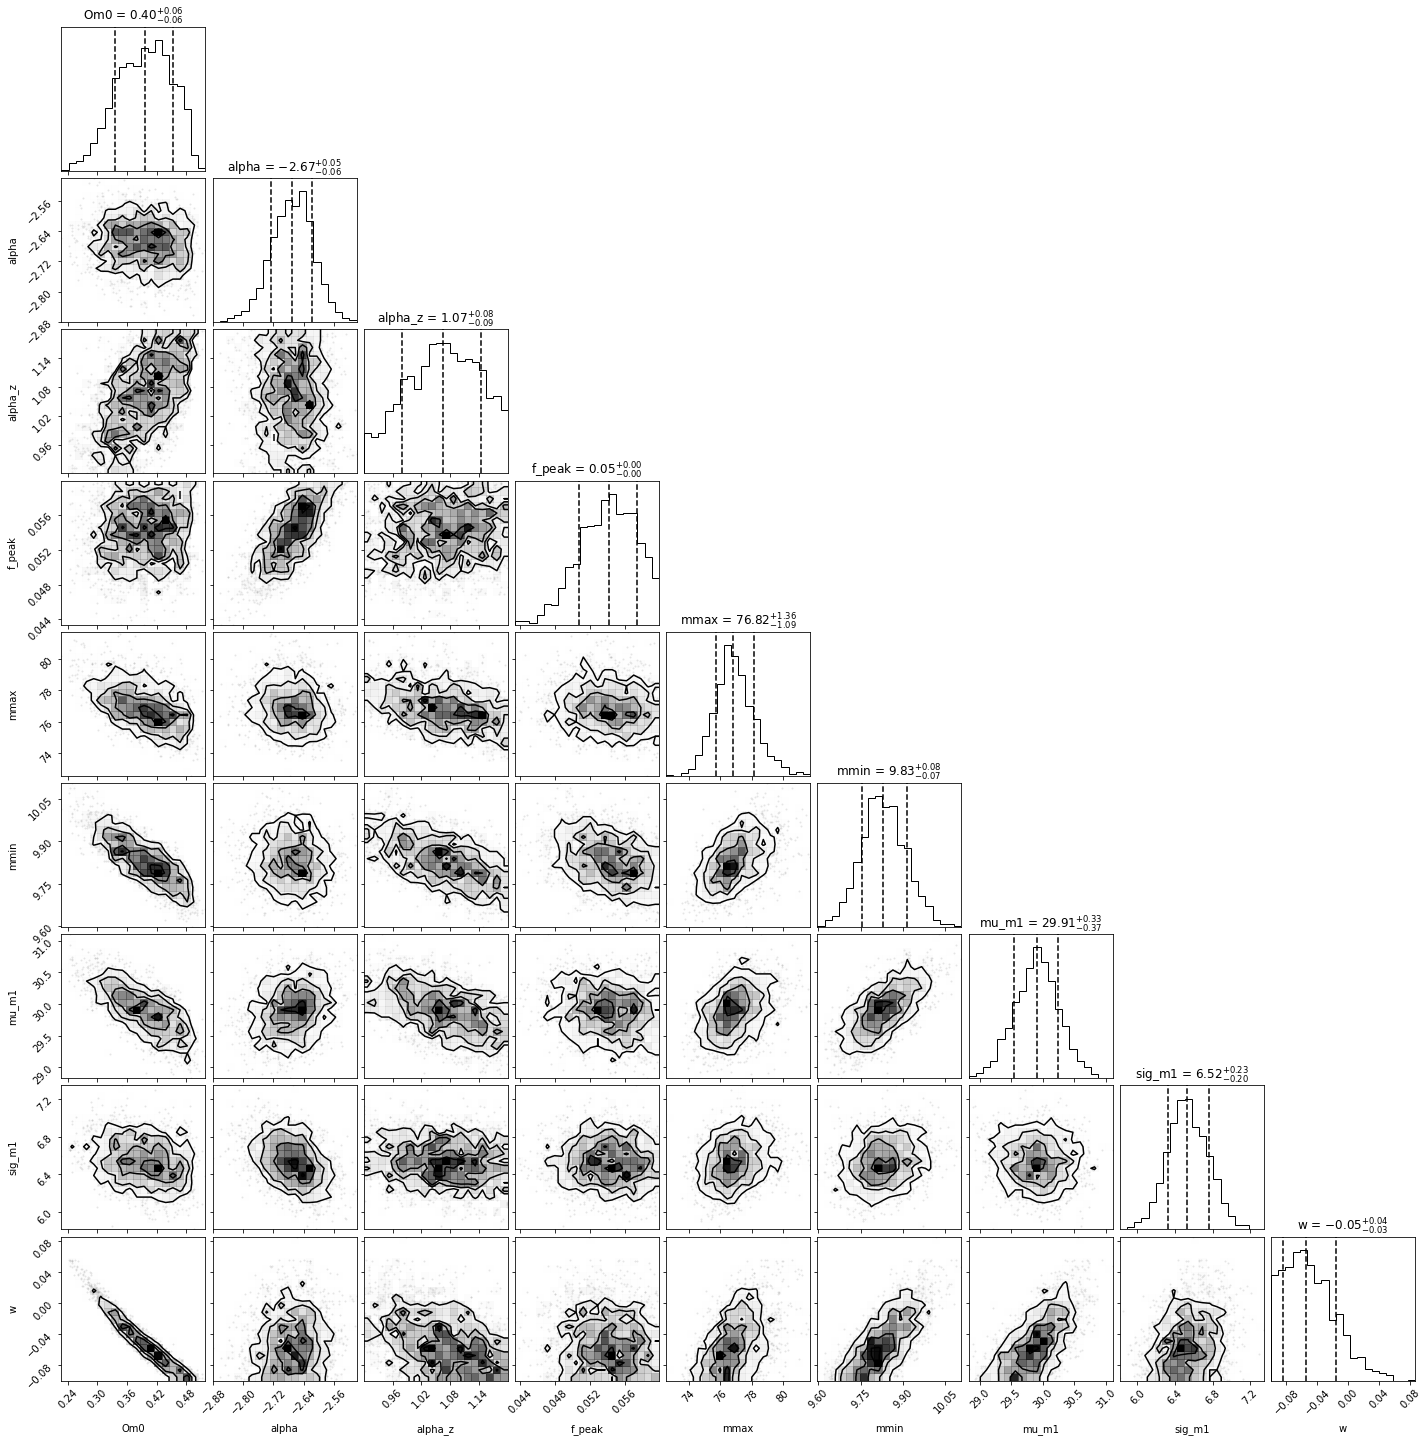

In [57]:
fig = corner.corner(
    samples2,quantiles=[0.16, 0.5, 0.84],#, labels=labels
                       show_titles=True,fontsize=fontsz,
    truths=[w_fid,Om0_fid,alpha_fid,alpha_z_fid,f_peak_fid,mmax_fid,mmin_fid,mu_m1_fid,sig_m1_fid]#, truths=[H0_fid/100,alpha_ml, zp_ml]
);
#plt.savefig('corner_wDM_2500stp_10kPts.png')
plt.show()

## Checking the tension with injected value

In [19]:
def dist_12_gauss(phases_1,truths):
    mean_1 = np.mean(phases_1,axis=0)
    mean_2 = truths
    Dphi_12 = mean_1 - mean_2

    
    cov_1 = np.cov(phases_1.T)
    cov_2 = 0.
    
    c12_inv = np.linalg.inv(cov_1 + cov_2)
    
    return np.sqrt(np.matmul(Dphi_12,np.matmul(c12_inv,Dphi_12)))

In [20]:
truths=np.array([Om0_fid,alpha_fid,alpha_z_fid,f_peak_fid,H0_fid/100,mmax_fid,mmin_fid,mu_m1_fid,sig_m1_fid])

In [21]:
dist_12_gauss(samples,truths)

AxisError: axis 0 is out of bounds for array of dimension 0

In [ ]:
len(samples[0,:])

In [ ]:
samples